In [1]:
%run data_package_loading.py # Code loads data as well as packages that are relevant across most project phases
%matplotlib inline

uci_features = ['28',  '48',  '64', '105', '128', '153', '241', '281', '318', '336', 
                '338', '378', '433', '442', '451', '453', '455', '472', '475', '493']

madelon_features = ['feat_257', 'feat_269', 'feat_308', 'feat_315', 'feat_336',
                   'feat_341', 'feat_395', 'feat_504', 'feat_526', 'feat_639',
                   'feat_681', 'feat_701', 'feat_724', 'feat_736', 'feat_769',
                   'feat_808', 'feat_829', 'feat_867', 'feat_920', 'feat_956']

Xuci_1 = Xuci_1[uci_features]
Xuci_2 = Xuci_2[uci_features]
Xuci_3 = Xuci_3[uci_features]

Xdb_1 = Xdb_1[madelon_features]
Xdb_2 = Xdb_2[madelon_features]
Xdb_3 = Xdb_3[madelon_features]

# !conda install -y psycopg2

from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel, RFECV 
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Trying SelectKBest()

In [2]:
def skb_features(X, y, k=5):
    skb = SelectKBest(k=k)
    skb.fit(X, y)
    
    ps = list(skb.pvalues_)
    features = skb.get_support()
    
    return ps, features

In [3]:
Xuci_1_pvals, Xuci_1_kfeatures = skb_features(Xuci_1, yuci_1)
Xuci_2_pvals, Xuci_2_kfeatures = skb_features(Xuci_2, yuci_2)
Xuci_3_pvals, Xuci_3_kfeatures = skb_features(Xuci_3, yuci_3)

Xdb_1_pvals, Xdb_1_kfeatures = skb_features(Xdb_1, ydb_1)
Xdb_2_pvals, Xdb_2_kfeatures = skb_features(Xdb_2, ydb_2)
Xdb_3_pvals, Xdb_3_kfeatures = skb_features(Xdb_3, ydb_3)


In [4]:
print(Xuci_1.columns[Xuci_1_kfeatures])
print(Xuci_2.columns[Xuci_2_kfeatures])
print(Xuci_3.columns[Xuci_3_kfeatures])

Index(['64', '128', '241', '336', '475'], dtype='object')
Index(['241', '338', '442', '472', '475'], dtype='object')
Index(['28', '64', '241', '336', '475'], dtype='object')


Similar but not identical results

In [5]:
print(Xdb_1.columns[Xdb_1_kfeatures])
print(Xdb_2.columns[Xdb_2_kfeatures])
print(Xdb_3.columns[Xdb_3_kfeatures])

Index(['feat_269', 'feat_341', 'feat_681', 'feat_769', 'feat_920'], dtype='object')
Index(['feat_269', 'feat_341', 'feat_681', 'feat_769', 'feat_920'], dtype='object')
Index(['feat_269', 'feat_341', 'feat_681', 'feat_701', 'feat_920'], dtype='object')


Very similar results

### SKB isn't returning consitent matches, but what if we bootstrap each sample?

In [6]:
def boot_skb(X, y, k=5, boots=20):
    np.random.seed(42) # set that seed
    size = len(X) #DecisionTreeClassifier// 2 # number of cases to include in each bootstrap sample
    
    pvals = [] # store list of lists for pvals 
    votes = [] # store list of lists for votes 
    
    for i in range(boots):
        boot_index = np.random.choice(X.index.tolist(), size = size, replace=True)
        
        X_bs = X.iloc[boot_index, :]
        y_bs = y[boot_index]
                
        ps, features = skb_features(X_bs, y_bs, k=k)
                
        pvals.append(ps)
        votes.append(features)
            
    pvals_df = pd.DataFrame(pvals, columns = X.columns)
    votes_df = pd.DataFrame(votes, columns = X.columns)
    
    mean_pvals = pvals_df.mean()
    sum_votes = votes_df.sum()
    
    return mean_pvals, sum_votes


In [7]:
Xuci_1_pvals, Xuci_1_kfeatures = boot_skb(Xuci_1, yuci_1, boots = 1000)
Xuci_2_pvals, Xuci_2_kfeatures = boot_skb(Xuci_2, yuci_2, boots = 1000)
Xuci_3_pvals, Xuci_3_kfeatures = boot_skb(Xuci_3, yuci_3, boots = 1000)

Xdb_1_pvals, Xdb_1_kfeatures = boot_skb(Xdb_1, ydb_1, boots = 1000)
Xdb_2_pvals, Xdb_2_kfeatures = boot_skb(Xdb_2, ydb_2, boots = 1000)
Xdb_3_pvals, Xdb_3_kfeatures = boot_skb(Xdb_3, ydb_3, boots = 1000)

In [8]:
print(set(Xuci_1_kfeatures.sort_values(ascending=False)[:5].index))
print(set(Xuci_2_kfeatures.sort_values(ascending=False)[:5].index))
print(set(Xuci_3_kfeatures.sort_values(ascending=False)[:5].index))

{'475', '64', '241', '336', '128'}
{'338', '472', '475', '241', '442'}
{'28', '475', '64', '241', '336'}


In [9]:
print(set(Xdb_1_kfeatures.sort_values(ascending=False)[:5].index))
print(set(Xdb_2_kfeatures.sort_values(ascending=False)[:5].index))
print(set(Xdb_3_kfeatures.sort_values(ascending=False)[:5].index))

{'feat_681', 'feat_341', 'feat_769', 'feat_269', 'feat_920'}
{'feat_681', 'feat_341', 'feat_769', 'feat_269', 'feat_920'}
{'feat_701', 'feat_681', 'feat_341', 'feat_269', 'feat_920'}


Neither set of samples are returning consistent sets of features when using 10000 bootstrap samples! Before moving on, let's check the top 10 features.

In [10]:
Xuci_1_pvals, Xuci_1_kfeatures = boot_skb(Xuci_1, yuci_1, k=10, boots = 1000)
Xuci_2_pvals, Xuci_2_kfeatures = boot_skb(Xuci_2, yuci_2, k=10, boots = 1000)
Xuci_3_pvals, Xuci_3_kfeatures = boot_skb(Xuci_3, yuci_3, k=10, boots = 1000)

Xdb_1_pvals, Xdb_1_kfeatures = boot_skb(Xdb_1, ydb_1, k=10, boots = 1000)
Xdb_2_pvals, Xdb_2_kfeatures = boot_skb(Xdb_2, ydb_2, k=10, boots = 1000)
Xdb_3_pvals, Xdb_3_kfeatures = boot_skb(Xdb_3, ydb_3, k=10, boots = 1000)

In [11]:
print(Xuci_1_kfeatures.sort_values(ascending=False)[:10].index.sort_values())
print(Xuci_2_kfeatures.sort_values(ascending=False)[:10].index.sort_values())
print(Xuci_3_kfeatures.sort_values(ascending=False)[:10].index.sort_values())

Index(['105', '128', '153', '241', '336', '338', '378', '475', '48', '64'], dtype='object')
Index(['128', '241', '336', '338', '442', '453', '472', '475', '493', '64'], dtype='object')
Index(['241', '28', '318', '336', '451', '453', '475', '48', '493', '64'], dtype='object')


In [12]:
print(Xdb_1_kfeatures.sort_values(ascending=False)[:10].index.sort_values())
print(Xdb_2_kfeatures.sort_values(ascending=False)[:10].index.sort_values())
print(Xdb_3_kfeatures.sort_values(ascending=False)[:10].index.sort_values())

Index(['feat_269', 'feat_336', 'feat_341', 'feat_681', 'feat_701', 'feat_736',
       'feat_769', 'feat_808', 'feat_829', 'feat_920'],
      dtype='object')
Index(['feat_269', 'feat_315', 'feat_336', 'feat_341', 'feat_681', 'feat_701',
       'feat_769', 'feat_808', 'feat_829', 'feat_920'],
      dtype='object')
Index(['feat_269', 'feat_315', 'feat_341', 'feat_681', 'feat_701', 'feat_736',
       'feat_769', 'feat_808', 'feat_829', 'feat_920'],
      dtype='object')


# RFE

In [13]:
def get_rfe(X, y, estimator = DecisionTreeClassifier(max_depth=10)):
    rfe = RFE(estimator = estimator, n_features_to_select=5)
    rfe.fit(X, y)
    
    return X.columns[rfe.get_support()]
     


In [15]:
get_rfe(Xuci_1, yuci_1)
get_rfe(Xuci_2, yuci_2)
get_rfe(Xuci_3, yuci_3)

get_rfe(Xdb_1, ydb_1)
get_rfe(Xdb_2, ydb_2)
get_rfe(Xdb_3, ydb_3)

Index(['feat_269', 'feat_308', 'feat_724', 'feat_769', 'feat_829'], dtype='object')

In [16]:
get_rfe(Xuci_1, yuci_1, LogisticRegression())
get_rfe(Xuci_2, yuci_2, LogisticRegression())
get_rfe(Xuci_3, yuci_3, LogisticRegression())

get_rfe(Xdb_1, ydb_1, LogisticRegression())
get_rfe(Xdb_2, ydb_2, LogisticRegression())
get_rfe(Xdb_3, ydb_3, LogisticRegression())

Index(['feat_257', 'feat_269', 'feat_395', 'feat_681', 'feat_829'], dtype='object')

Also getting inconsitent results, particularly accross estimators. Let's try bootstrapping here as well.

In [17]:
def boot_rfe(X, y, estimator = DecisionTreeClassifier(max_depth=10), boots=20):
    np.random.seed(42) # set that seed
    size = len(X) #DecisionTreeClassifier// 2 # number of cases to include in each bootstrap sample
    
    votes = {} # store list of lists for votes 
    
    for i in range(boots):
        boot_index = np.random.choice(X.index.tolist(), size = size, replace=True)
        
        X_bs = X.iloc[boot_index, :]
        y_bs = y[boot_index]
                
        features = get_rfe(X_bs, y_bs, estimator)
                
        for fea in features:
            if fea in votes.keys():
                votes[fea] += 1
            else:
                votes[fea] = 1
        
    return votes


In [19]:
Xuci_1_rfe_features = boot_rfe(Xuci_1, yuci_1, boots = 100)
Xuci_2_rfe_features = boot_rfe(Xuci_2, yuci_2, boots = 100)
Xuci_3_rfe_features = boot_rfe(Xuci_3, yuci_3, boots = 100)

Xdb_1_rfe_features = boot_rfe(Xdb_1, ydb_1, boots = 100)
Xdb_2_rfe_features = boot_rfe(Xdb_2, ydb_2, boots = 100)
Xdb_3_rfe_features = boot_rfe(Xdb_3, ydb_3, boots = 100)


KeyboardInterrupt: 

In [ ]:
print(pd.Series(Xuci_1_rfe_features).sort_values(ascending = False)[:5].index)
print(pd.Series(Xuci_2_rfe_features).sort_values(ascending = False)[:5].index)
print(pd.Series(Xuci_3_rfe_features).sort_values(ascending = False)[:5].index)

In [ ]:
print(pd.Series(Xdb_1_rfe_features).sort_values(ascending = False)[:5].index)
print(pd.Series(Xdb_2_rfe_features).sort_values(ascending = False)[:5].index)
print(pd.Series(Xdb_3_rfe_features).sort_values(ascending = False)[:5].index)

Blast! Still inconsistent results

### Let's take a look at RandomForest's feature importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

In [ ]:
def rfc_gridsearch(X, y):
    rfc_param = {'n_estimators': [10, 50, 100, 500, 1000],
                'max_depth': [1, 5, 10, None],
                'max_features': ['auto', 'log2', 'sqrt']}

    rfc_gs = GridSearchCV(RandomForestClassifier(),
                         rfc_param,
                         cv=5,
                         n_jobs = -1)
    
    rfc_gs.fit(X, y)
    
    importance_df = pd.DataFrame(list(zip(X.columns, rfc_gs.best_estimator_.feature_importances_)), 
                                 columns = ['Feature', 'Importance'])
    
    return importance_df

In [ ]:
uci1_rfgs_importance = rfc_gridsearch(Xuci_1, yuci_1)
uci1_rfgs_importance = rfc_gridsearch(Xuci_2, yuci_2)
uci3_rfgs_importance = rfc_gridsearch(Xuci_3, yuci_3)
db1_rfgs_importance = rfc_gridsearch(Xdb_1, ydb_1)
db2_rfgs_importance = rfc_gridsearch(Xdb_2, ydb_2)
db3_rfgs_importance = rfc_gridsearch(Xdb_3, ydb_3)

In [ ]:
2+2

In [ ]:
uci1_rfgs_importance.sort_values('Importance', ascending=False).head().T

In [ ]:
uci2_rfgs_importance.sort_values('Importance', ascending=False).head().T

In [ ]:
uci3_rfgs_importance.sort_values('Importance', ascending=False).head().T

In [ ]:
db1_rfgs_importance.sort_values('Importance', ascending=False).head().T

In [ ]:
db2_rfgs_importance.sort_values('Importance', ascending=False).head().T

In [ ]:
db3_rfgs_importance.sort_values('Importance', ascending=False).head().T

### Feature Reduction results aren't unambiguously clear
Let's take a step back and see if we can identify the 5 most independent features.

In [2]:
def make_heat(df):
    corr_df = df.corr().sort_values(by=df.columns[0]).sort_values(by=df.columns[0],axis=1)
    sns.heatmap(corr_df, cmap='RdBu_r')


<function matplotlib.pyplot.tight_layout>

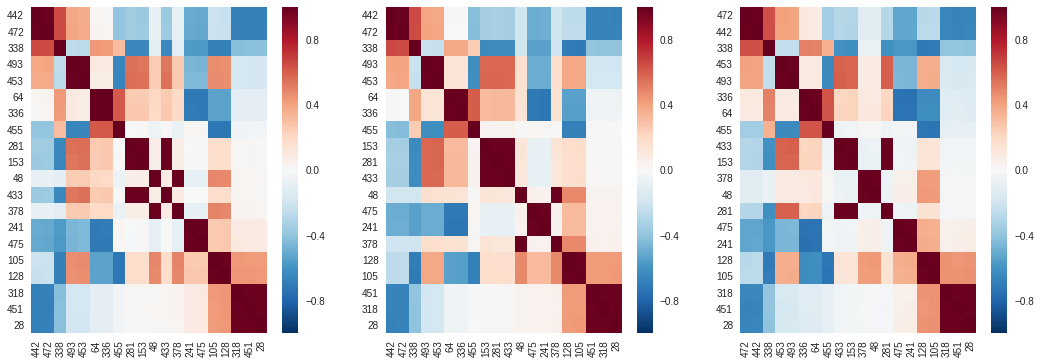

In [3]:
fig = plt.figure(figsize=(18,6))

for i, df in enumerate([Xuci_1, Xuci_2, Xuci_3]):
    fig.add_subplot(1,3,1+i)
    
    make_heat(df)
    
plt.tight_layout

Some fruitful results! It appears that there are 8 groups of highly correlated features, along with two relatively independent features, making a total of 10 groups.

|Feature|Notes|Grouping|
|---|---|---|
|'28'|0.99 correlations with `318` and `451`|A|
|'451'|0.99 correlations with `28` and `318`|A|
|'318'|0.99 correlations with `28` and `451`|A|
|'105'|0.99 correlation with `128`|B|
|'128'|0.99 correlation with `105`|B|
|'241'|0.99 correlation with `475`|C|
|'475'|0.99 correlation with `241`|C|
|'378'|0.99 correlation with `48`|D|
|'48'|0.99 correlation with `378`|D|
|'153'|0.99 correlations with `281` and `433`|E|
|'281'|0.99 correlations with `153` and `433`|E|
|'433'|0.99 correlations with `153` and `281`|E|
|'64'|0.99 correlation with `336`|F|
|'336'|0.99 correlation with `64`|F|
|'453'|0.99 correlation with `493`|G|
|'493'|0.99 correlation with `453`|G|
|'442'|0.99 correlation with `472`|H|
|'472'|0.99 correlation with `442`|H|
|'338'|Looks relatively independent at first glance|J|
|'455'|Looks relatively independent at first glance|K|


Let's take a look at the heatmaps after grouping the related features

<function matplotlib.pyplot.tight_layout>

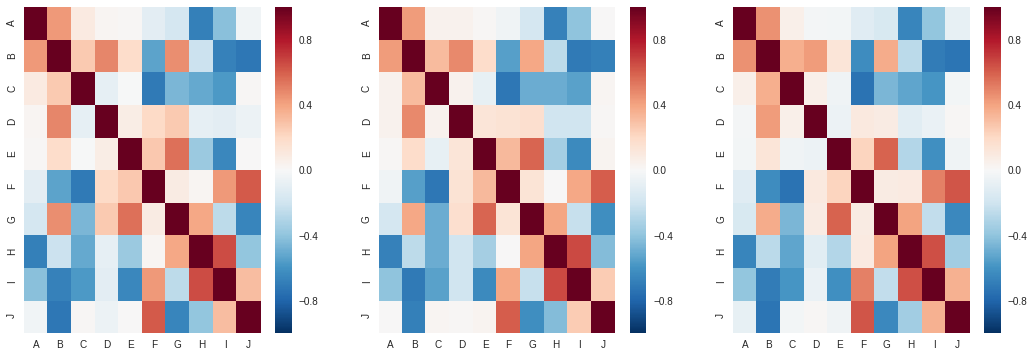

In [81]:
def make_heat(df):
    corr_df = df.corr()
    sns.heatmap(corr_df, cmap='RdBu_r')

fig = plt.figure(figsize=(18,6))

for i, df in enumerate([Xuci_1, Xuci_2, Xuci_3]):
    grouped_df = pd.DataFrame()
    grouped_df['A'] = df[['28','451','318']].mean(axis=1)
    grouped_df['B'] = df[['105','128']].mean(axis=1)
    grouped_df['C'] = df[['241','475']].mean(axis=1)
    grouped_df['D'] = df[['378','48']].mean(axis=1)
    grouped_df['E'] = df[['153','281','433']].mean(axis=1)
    grouped_df['F'] = df[['64','336']].mean(axis=1)
    grouped_df['G'] = df[['453', '493']].mean(axis=1)
    grouped_df['H'] = df[['472','442']].mean(axis=1)
    grouped_df['I'] = df[['338']].mean(axis=1)
    grouped_df['J'] = df[['455']].mean(axis=1)
    
    fig.add_subplot(1,3,1+i)
    
    make_heat(grouped_df)
    
plt.tight_layout

The grouped features do not appear to show any obvious direct correlations. Still, we have cut our features in half. 

<function matplotlib.pyplot.tight_layout>

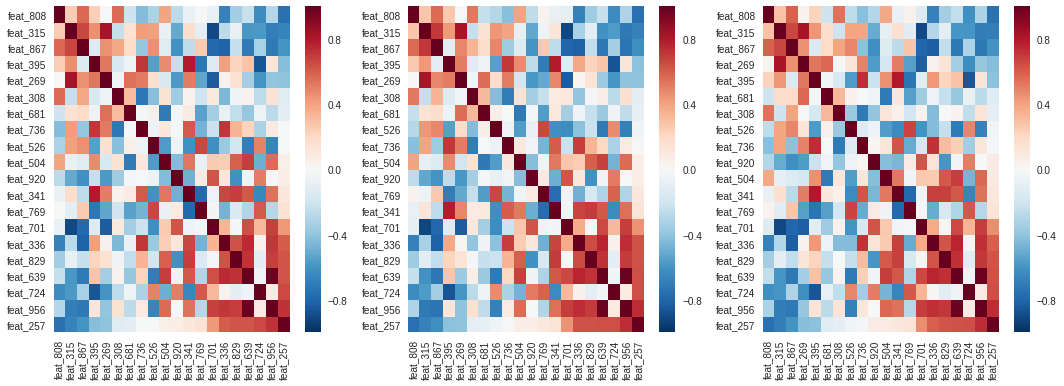

In [4]:
def make_heat(df):
    tmp_df = df
    corr_df = tmp_df.corr().sort_values(by=df.columns[0]).sort_values(by=df.columns[0],axis=1)
    sns.heatmap(corr_df)


fig = plt.figure(figsize=(18,6))

for i, df in enumerate([Xdb_1, Xdb_2, Xdb_3]):
    fig.add_subplot(1,3,1+i)
    
    make_heat(df)
    
plt.tight_layout

Afer some playing around, I was unable to find groupings as clear as with the UCI data. From prior EDA, the features appeared to be symetrical, but let's test that.

In [167]:
from scipy import stats

In [187]:
for col in Xdb_1.columns:
    print(col, stats.skewtest(Xdb_1[col]))

feat_257 SkewtestResult(statistic=-2.4309007796833226, pvalue=0.015061338428075879)
feat_269 SkewtestResult(statistic=-1.0815576181942286, pvalue=0.27944914526124809)
feat_308 SkewtestResult(statistic=2.3940885587363017, pvalue=0.016661725297296582)
feat_315 SkewtestResult(statistic=-1.1625497414740247, pvalue=0.24501223209656431)
feat_336 SkewtestResult(statistic=-0.30237735156280571, pvalue=0.76236441799573118)
feat_341 SkewtestResult(statistic=-0.29546995359285172, pvalue=0.76763490183661154)
feat_395 SkewtestResult(statistic=-2.0752448483706996, pvalue=0.037963848017208472)
feat_504 SkewtestResult(statistic=2.1393032065528632, pvalue=0.032411120182284259)
feat_526 SkewtestResult(statistic=-1.5340581447216901, pvalue=0.12501534904026548)
feat_639 SkewtestResult(statistic=2.7892105471789299, pvalue=0.0052836703093431759)
feat_681 SkewtestResult(statistic=-0.31343973601088049, pvalue=0.75394659905936035)
feat_701 SkewtestResult(statistic=1.1087814398431539, pvalue=0.26752447910225952)

SKEW! Time for a Box-Cox transformation. Since some values are negative, we will have to add an arbitrary constant

In [188]:
for col in Xdb_1.columns:
    print("boxcox "+col, stats.skewtest(stats.boxcox(Xdb_1[col]+15)[0])) 
    #15 is an arbitraty constant to make all values positive

boxcox feat_257 SkewtestResult(statistic=0.10462082679881489, pvalue=0.91667668800202795)
boxcox feat_269 SkewtestResult(statistic=0.64048201419605111, pvalue=0.52185927847660385)
boxcox feat_308 SkewtestResult(statistic=0.1530849750313375, pvalue=0.87833126440265141)
boxcox feat_315 SkewtestResult(statistic=0.29460576507139069, pvalue=0.76829505765185879)
boxcox feat_336 SkewtestResult(statistic=0.19333619573541355, pvalue=0.84669568094942549)
boxcox feat_341 SkewtestResult(statistic=0.42552457819832423, pvalue=0.67045430840633768)
boxcox feat_395 SkewtestResult(statistic=0.67909833479793869, pvalue=0.49707555750697952)
boxcox feat_504 SkewtestResult(statistic=0.090202026725197115, pvalue=0.92812667380086933)
boxcox feat_526 SkewtestResult(statistic=0.048583208090562109, pvalue=0.96125145216398278)
boxcox feat_639 SkewtestResult(statistic=0.16437563474430378, pvalue=0.86943544332556777)
boxcox feat_681 SkewtestResult(statistic=-0.12571757574408735, pvalue=0.89995548882011034)
boxcox f

Much better, let's transform the data and see what the heatmap looks like.

In [226]:
def boxcox_df(df, c=15):
    bc_df = df
    
    for col in df.columns:
#         bc_df[col] = stats.boxcox(df[col]+c)[0]
        bc_df[col] = stats.boxcox(df[col])[0]
        
    return bc_df

In [227]:
Xdb_1_bc = boxcox_df(Xdb_1)
Xdb_2_bc = boxcox_df(Xdb_2)
Xdb_3_bc = boxcox_df(Xdb_3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [228]:
Xdb_1_bc.head()

,feat_257,feat_269,feat_308,feat_315,feat_336,feat_341,feat_395,feat_504,feat_526,feat_639,feat_681,feat_701,feat_724,feat_736,feat_769,feat_808,feat_829,feat_867,feat_920,feat_956
0,29.446238,13.392378,5.852838,15.879076,12.245502,9.497756,16.905121,5.337966,23.005981,5.350331,13.788166,11.615127,18.714951,14.275842,3.413967,5.605446,5.632266,6.532532,17.780943,8.736687
1,34.616602,14.129730,7.255437,13.905344,13.847370,15.325651,18.845374,7.371862,17.827673,7.068386,13.624372,12.253113,15.467140,12.804458,3.087197,5.963930,8.420951,6.654498,13.330837,11.472441
2,22.746231,22.331138,6.444799,22.414992,11.494820,15.241029,24.949534,6.468519,21.509844,5.111701,14.681864,7.568407,10.700089,16.202119,2.924952,6.453883,6.794520,7.937028,12.645878,8.022497
3,25.608474,18.520826,7.106927,17.957005,12.532147,16.104149,24.425542,6.933493,17.180879,6.120675,14.712933,10.615437,11.147307,14.611100,2.715232,6.544116,6.953935,7.168554,13.760985,9.729946
4,28.975110,16.635958,4.751683,18.866774,14.262633,11.019058,20.068799,5.196776,25.079654,5.196193,13.540929,10.025205,18.066126,17.958710,3.354866,5.096361,6.089152,6.343929,17.624485,8.222386


<function matplotlib.pyplot.tight_layout>

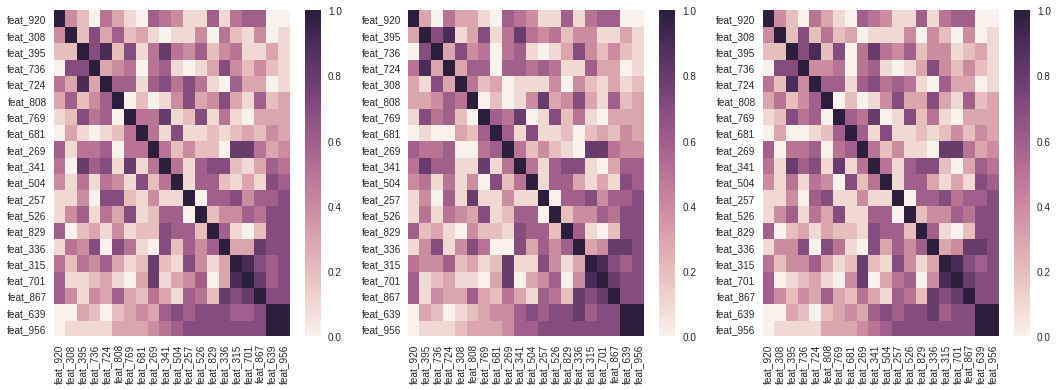

In [249]:
def make_heat(df):
    tmp_df = df
    corr_df = round(abs(tmp_df.corr()),1)
    sns.heatmap(corr_df.sort_values(by=corr_df.columns[-1]).sort_values(by=corr_df.columns[-1], axis=1))


fig = plt.figure(figsize=(18,6))

for i, df in enumerate([Xdb_1_bc, Xdb_2_bc, Xdb_3_bc]):
    fig.add_subplot(1,3,1+i)
    
    make_heat(df)
    
plt.tight_layout

In [253]:
Xdb_1_bc[['feat_336']].corrwith(Xdb_1_bc['feat_867'])

feat_336   -0.811811
dtype: float64

In [271]:
Xdb_1_bc.corrwith(Xdb_1_bc['feat_829']).sort_values()

feat_920   -0.603508
feat_808   -0.350900
feat_681   -0.243654
feat_867   -0.234370
feat_526   -0.193108
feat_769   -0.149947
feat_724   -0.099552
feat_315   -0.076355
feat_308   -0.039492
feat_701   -0.019674
feat_269    0.153492
feat_395    0.221864
feat_736    0.334804
feat_504    0.592085
feat_257    0.625642
feat_336    0.636149
feat_341    0.688656
feat_956    0.693698
feat_639    0.718755
feat_829    1.000000
dtype: float64

|Feature|Notes|Grouping|
|---|---|---|
|'feat_956'|0.98 correlation with `feat_639`|A|
|'feat_639'|0.98 correlation with `feat_956`|A|
|'feat_829'||A|

|'feat_269'|0.83 correlation with `feat_315`|B|
|'feat_315'|0.83 correlation with `feat_269`|B|
|'feat_701'|B|

|'feat_341'|0.79 correlation with `feat_395`|C|
|'feat_395'|0.79 correlation with `feat_341`|C|
|'feat_724'|C|
|'feat_769'|C|



|'feat_336'|-0.81 correlation with `feat_867`|D|
|'feat_867'|-0.81 correlation with `feat_336`|D|

|'feat_808'|-0.75 correlation with `feat_257`|E|
|'feat_257'|-0.75 correlation with `feat_808`|E|
|'feat_308'|-0.72 correlation with `feat_736`|F|
|'feat_736'|-0.72 correlation with `feat_308`|F|
|'feat_504'|-0.70 correlation with `feat_681`|G|
|'feat_681'|-0.70 correlation with `feat_681`|G|
|'feat_526'|||

|'feat_920'|larget magnitude correlations are ~0.6. Possibly independent?||



In [262]:
abs(Xdb_1_bc.corr()).sum().sort_values()

feat_681    5.350332
feat_308    5.763073
feat_920    6.647440
feat_808    7.344569
feat_736    7.366986
feat_769    7.407981
feat_504    7.660614
feat_829    7.675705
feat_257    8.134427
feat_526    8.354528
feat_701    8.391891
feat_395    8.509384
feat_724    8.628654
feat_269    8.647424
feat_315    9.061888
feat_341    9.271078
feat_336    9.403775
feat_867    9.643491
feat_956    9.650809
feat_639    9.889445
dtype: float64

In [ ]:
feat_257 feat_956 feat_336 feat_639 feat_736 feat_956 feat_341 feat_395 feat_829
feat_269 feat_315
feat_308
feat_504
feat_526
feat_681
feat_701
feat_724
feat_769
feat_808
feat_867
feat_920